In [4]:
!pip install numpy==2.2.0


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# -*- coding: utf-8 -*-
"""Modeling Climate Impact on Sickle Cell Mortality Risk in Africa.ipynb

# **Importing Libraries**
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
from statsmodels.tsa.vector_ar.var_model import VAR
import traceback
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

# **Data Augmentation**

In [6]:
# Denton-Cholette–Style Disaggregation

def denton_disaggregate(yearly_total, indicator_series, smooth_order=2):
    indicators = np.maximum(indicator_series, 0.01)
    indicators = indicators / indicators.sum()
    initial = yearly_total * indicators

    def objective(x):
        return np.sum(np.diff(x, n=smooth_order) ** 2)

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - yearly_total}]
    bounds = [(0, None)] * 12

    res = minimize(objective, initial, method='SLSQP', bounds=bounds, constraints=constraints)

    if not res.success:
        return np.round(initial).astype(int)

    raw = res.x
    floored = np.floor(raw).astype(int)
    diff = int(round(yearly_total)) - floored.sum()

    if diff > 0:
        for i in np.argsort(raw - floored)[-diff:]:
            floored[i] += 1
    elif diff < 0:
        for i in np.argsort(floored - raw)[:abs(diff)]:
            floored[i] -= 1

    return np.maximum(floored, 0)

# Estimating country-specific weights
def get_country_climate_weights(final_data, Value):
    weights = {}
    features = ['yearly_avg_temperature', 'yearly_avg_precipitation']

    for country, group in final_data.groupby('country_code'):
        group_yearly = group.drop_duplicates(subset='year')
        if len(group_yearly) < 2:
            continue

        X = group_yearly[features].values
        y = group_yearly[Value].values

        if np.all(np.isnan(y)) or np.all(y == y[0]):
            continue

        model = LinearRegression().fit(X, y)
        weights[country] = tuple(model.coef_)

    return weights

# Applying Denton disaggregation
def disaggregate_monthly(final_data, Value, weights_by_country):
    output_col = f'monthly_{Value}'
    final_data[output_col] = np.nan

    for (country, year), group in final_data.groupby(['country_code', 'year']):
        if len(group) != 12 or pd.isna(group[Value].iloc[0]):
            continue

        temp = group['tavg_temperature'].values
        precip = group['avg_precipitation'].values
        weights = weights_by_country.get(country, (0.5, 0.5))

        indicators = weights[0] * temp + weights[1] * precip
        monthly = denton_disaggregate(group[Value].iloc[0], indicators)

        final_data.loc[group.index, output_col] = monthly

    final_data[output_col] = final_data[output_col].astype("Int64")
    return final_data

merged_data = pd.read_csv('Preprocessed and Merged Climate and SCA data.csv')

final_aug_data = disaggregate_monthly(merged_data, 'Value', get_country_climate_weights(merged_data, 'Value'))

# imputation for missing mortality values
def impute_monthly_mortality(df, monthly_col, yearly_col):
    df = df.copy()

    for (country, year), group in df.groupby(["country_code", "year"]):
        if pd.isna(year) or pd.isna(country):
            continue

        yearly_total = group[yearly_col].iloc[0]
        if pd.isna(yearly_total):
            continue

        indices = group.index
        monthly_vals = df.loc[indices, monthly_col].values

        known_mask = ~pd.isna(monthly_vals)
        known_sum = round(monthly_vals[known_mask].sum()) if known_mask.any() else 0
        count_known = known_mask.sum()
        missing_mask = pd.isna(monthly_vals)
        count_missing = 12 - count_known

        # Handle edge case: more than 12 or fewer than 12 months in data
        if count_missing <= 0:
            df.loc[indices[missing_mask], monthly_col] = 0
            continue

        if known_sum >= round(yearly_total):
            df.loc[indices[missing_mask], monthly_col] = 0
        else:
            residual = round(yearly_total) - known_sum
            per_month_value = round(residual / count_missing)
            df.loc[indices[missing_mask], monthly_col] = per_month_value

    df[monthly_col] = df[monthly_col].astype("Int64")
    return df

final_filled_data = impute_monthly_mortality(final_aug_data, 'monthly_Value', 'Value')

# **Feature Generation**

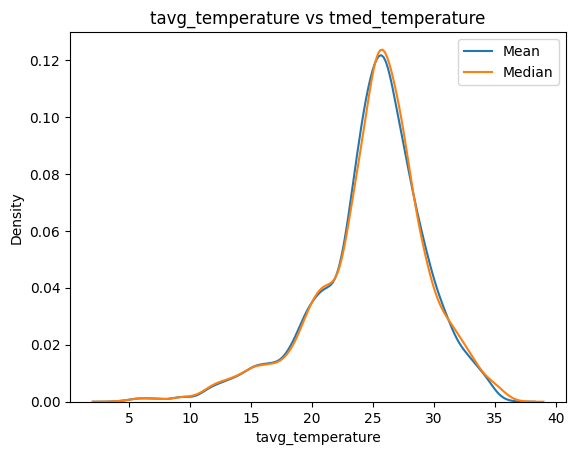

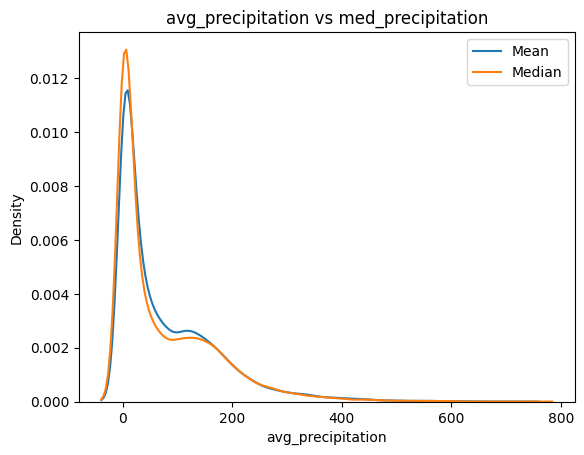

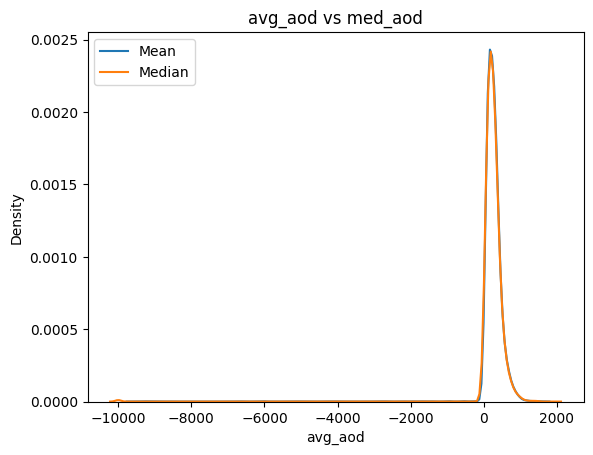

In [7]:
df = final_filled_data

# dropping yearly values used previously to aid augmentation
df = df.drop(columns=['Value', 'yearly_avg_temperature', 'yearly_avg_precipitation'])
df.rename(columns={'monthly_Value': 'Value'}, inplace=True)

#round death values
df['Value'] = df['Value'].round(0).clip(lower=0)

#Creating Composite features
# Range-based interaction terms
df['temp_range'] = df['tmax_temperature'] - df['tmin_temperature']
df['precip_range'] = df['max_precipitation'] - df['min_precipitation']
df['aod_range'] = df['max_aod'] - df['min_aod']

# Interaction terms
df['aridity_index'] = df['avg_precipitation']//(df['tavg_temperature'] + 10) # De Martonne aridity index

# Skewness Evaluation
dfX = df

# Identifying mean vs median feature columns
mean_cols = [col for col in dfX.columns if 'avg_' in col]
median_cols = [col for col in dfX.columns if 'med_' in col]

# Filtering only numeric columns to avoid dtype issues
mean_cols = [col for col in mean_cols if pd.api.types.is_numeric_dtype(dfX[col])]
median_cols = [col for col in median_cols if pd.api.types.is_numeric_dtype(dfX[col])]

# Evaluating skewness for each pair
results = []
for mean_col in mean_cols:
    # Infer corresponding median col
    med_col = mean_col.replace('avg_', 'med_')
    if med_col in median_cols:
        mean_skew = skew(dfX[mean_col].dropna())
        med_skew = skew(dfX[med_col].dropna())
        decision = 'drop_median' if abs(mean_skew) < abs(med_skew) else 'drop_mean'
        results.append({
            'feature_pair': (mean_col, med_col),
            'mean_skew': mean_skew,
            'median_skew': med_skew,
            'drop': decision
        })

# Creating DataFrame with results
skewness_dfX = pd.DataFrame(results)
skewness_dfX = skewness_dfX.sort_values(by='drop')

# Visualising results of Fisher-Pearson coefficient of skewness.
for row in results:
    sns.kdeplot(dfX[row['feature_pair'][0]].dropna(), label='Mean')
    sns.kdeplot(dfX[row['feature_pair'][1]].dropna(), label='Median')
    plt.title(f"{row['feature_pair'][0]} vs {row['feature_pair'][1]}")
    plt.legend()
    plt.show()

skewness_dfX

# Dropping columns with higher absolute skew toward better stability for modeling.
df = df.drop(columns=['tavg_temperature', 'avg_precipitation', 'med_aod'])

# Dropping columns based on results from EDA and granger causality testing
df = df.drop(columns=['min_aod', 'avg_aod', 'aod_range'])

# Adding lag features and rolling average features to capture delayed health effects of climate stressors.

# Ensuring correct sort order
df = df.sort_values(['Location', 'year', 'month_number']).reset_index(drop=True)

# Variables
all_vars = ['tmin_temperature', 'precip_range', 'temp_range',
 'max_aod', 'max_precipitation', 'tmed_temperature',
 'aridity_index', 'med_precipitation',
 'tmax_temperature', 'min_precipitation'
]

# Lags (in months)
lags = [1, 3]

# Rolling windows (in months)
windows = [3, 6]

# LAG FEATURES
for var in all_vars:
    for lag in lags:
        df[f'{var}_lag{lag}'] = df.groupby('Location')[var].shift(lag)

# ROLLING FEATURES (trailing only)
for var in all_vars:
    for window in windows:
        df[f'{var}_roll{window}'] = (
            df.groupby('Location')[var]
              .shift(1)  # excluding current month to prevent leakage
              .rolling(window=window, min_periods=1)
              .mean()
              .reset_index(level=0, drop=True)
        )

# Encoding cyclicality and indicating that December and January are adjacent
df['month_sin'] = np.sin(2 * np.pi * df['month_number'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_number'] / 12)
final_df = df.copy().reset_index(drop=True)

#**Feature Selection and Modeling**

## **Region Specific Model for Central Africa**

###**Feature Selection**

In [8]:
df = final_df[final_df['region'] == 'Central Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

#low importance features
low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
df = df.drop(columns=low_importance_collinear_features)

# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

# VIF***********
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
df = df.drop(columns=high_VIF_features)

### **Selected Features**

In [9]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features

,feature,importance,VIF
0,month_sin,0.203893,1.107745
1,precip_range,0.174824,1.277009
2,max_aod,0.148218,1.305892
3,max_aod_lag3,0.102091,1.787667
4,max_aod_lag1,0.101633,1.569055
5,tmed_temperature,0.099504,1.074139
6,max_aod_roll6,0.090442,2.455092
7,month_cos,0.079395,1.103090


###**Modeling**

Best iteration: 240
Best score on validation set: 37.4259659531316
RMSE on validation set using best model: 37.425966960516696
RMSE: 37.36
MAE: 22.08
R²: 0.580
MAPE: 287.93


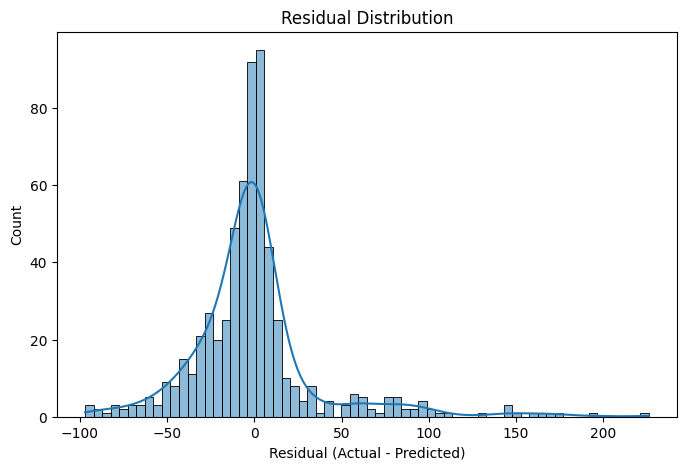

In [10]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Extracting SHAP Values For Explainability
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
Central_Africa = impact_df[columns_to_keep].copy()

## **Region Specific Model for East Africa**

###**Feature Selection**

In [11]:
df = final_df[final_df['region'] == 'East Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
df = df.drop(columns=low_importance_collinear_features)

# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
df = df.drop(columns=high_VIF_features)

### **Selected Features**

In [12]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features

,feature,importance,VIF
0,max_aod_roll6,0.190442,3.681878
1,month_sin,0.182621,1.285127
2,precip_range,0.170710,1.130144
3,month_cos,0.167585,1.081619
4,min_precipitation_lag1,0.098978,1.341208
5,max_aod,0.068326,1.730209
6,max_aod_lag1,0.061281,2.293657
7,max_aod_lag3,0.060057,2.574553


###**Modeling**

Best iteration: 168
Best score on validation set: 10.8491074096198
RMSE on validation set using best model: 10.849107106117074
RMSE: 10.83
MAE: 6.08
R²: 0.510
MAPE: <NA>


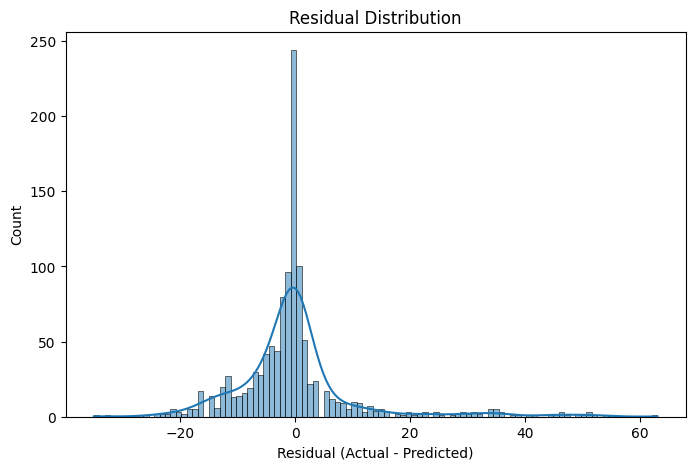

In [13]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Extracting SHAP Values For Explainability
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
East_Africa = impact_df[columns_to_keep].copy()

## **Region Specific Model for North Africa**

###**Feature Selection**

In [14]:
df = final_df[final_df['region'] == 'North Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
df = df.drop(columns=low_importance_collinear_features)

# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
df = df.drop(columns=high_VIF_features)

### **Selected Features**

In [15]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features

,feature,importance,VIF
0,precip_range_roll6,0.366074,3.614359
1,temp_range_roll6,0.102261,2.324020
2,month_sin,0.085153,1.698512
3,max_aod_lag1,0.065975,2.793010
4,max_aod_roll3,0.059507,6.548824
5,max_aod,0.059068,1.206794
6,med_precipitation_roll6,0.055396,1.594608
7,max_aod_lag3,0.050053,2.769073
8,precip_range,0.030029,2.107784
9,max_aod_roll6,0.029805,3.242366


###**Modeling**

Best iteration: 199
Best score on validation set: 1.7512517720409329
RMSE on validation set using best model: 1.751251794785554
RMSE: 1.75
MAE: 0.94
R²: 0.817
MAPE: 26.01


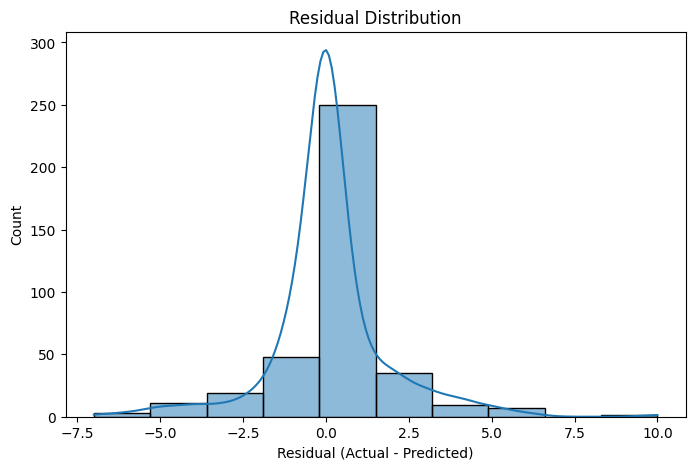

In [16]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Extracting SHAP Values For Explainability
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
North_Africa = impact_df[columns_to_keep].copy()

## **Region Specific Model for Southern Africa**

###**Feature Selection**

In [17]:
df = final_df[final_df['region'] == 'Southern Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
df = df.drop(columns=low_importance_collinear_features)

# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
df = df.drop(columns=high_VIF_features)

### **Selected Features**

In [18]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features

,feature,importance,VIF
0,max_aod_roll6,0.448639,4.534779
1,min_precipitation,0.114401,2.053965
2,month_sin,0.093298,1.684897
3,precip_range,0.082066,2.146061
4,max_aod,0.068873,1.648404
5,med_precipitation_lag1,0.059953,2.595726
6,max_aod_lag3,0.047307,2.368657
7,precip_range_lag1,0.046750,2.803250
8,max_aod_lag1,0.038712,2.258184


###**Modeling**

Best iteration: 518
Best score on validation set: 0.3914336514601378
RMSE on validation set using best model: 0.3914336417658386
RMSE: 0.43
MAE: 0.16
R²: 0.743
MAPE: <NA>


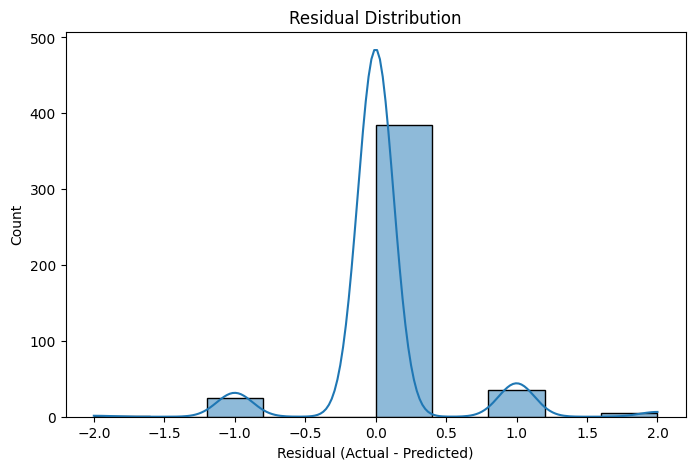

In [19]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Extracting SHAP Values For Explainability
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
Southern_Africa = impact_df[columns_to_keep].copy()

## **Region Specific Model for West Africa**

###**Feature Selection**

In [20]:
df = final_df[final_df['region'] == 'West Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
df = df.drop(columns=low_importance_collinear_features)

# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
df = df.drop(columns=high_VIF_features)

### **Selected Features**

In [21]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features_importance = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features_importance = features_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)
features_importance

,feature,importance,VIF
0,max_aod_roll6,0.359339,2.742564
1,precip_range,0.104860,1.688171
2,month_cos,0.090696,2.653453
3,max_aod,0.081598,1.306699
4,min_precipitation_roll6,0.071997,2.759442
5,min_precipitation,0.069031,3.614839
6,tmin_temperature,0.060841,1.542198
7,month_sin,0.057719,1.620935
8,tmax_temperature,0.046070,2.375231
9,max_aod_lag1,0.023474,1.712342


In [22]:
features_importance

,feature,importance,VIF
0,max_aod_roll6,0.359339,2.742564
1,precip_range,0.104860,1.688171
2,month_cos,0.090696,2.653453
3,max_aod,0.081598,1.306699
4,min_precipitation_roll6,0.071997,2.759442
5,min_precipitation,0.069031,3.614839
6,tmin_temperature,0.060841,1.542198
7,month_sin,0.057719,1.620935
8,tmax_temperature,0.046070,2.375231
9,max_aod_lag1,0.023474,1.712342


###**Modeling**

Best iteration: 668
Best score on validation set: 67.67767557744007
RMSE on validation set using best model: 67.67767414831127
RMSE: 67.61
MAE: 37.79
R²: 0.888
MAPE: 140.38


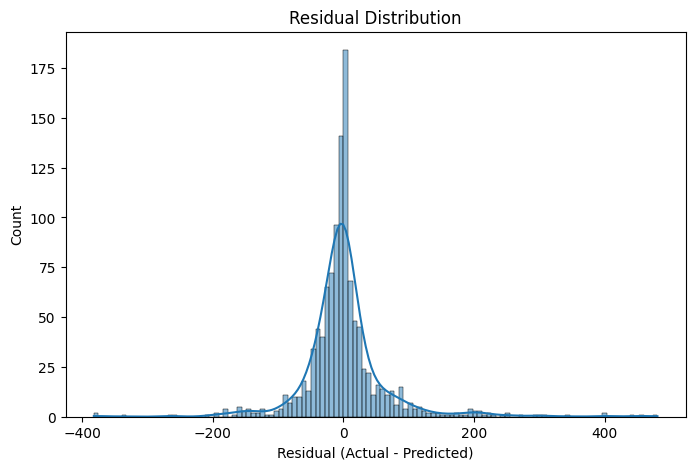

In [23]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

# Residual Analysis:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Extracting SHAP Values For Explainability
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
West_Africa = impact_df[columns_to_keep].copy()

In [24]:
#print(X)

##**Forecast**

In [25]:
#Combining all
df_combined = pd.concat([Central_Africa, East_Africa, North_Africa, Southern_Africa, West_Africa], ignore_index=True)
df_combined['climate_score'] = df_combined['climate_score'].astype(int)

model_df = df_combined.copy().reset_index(drop=True)

# install if not already installed
# !pip install pmdarima

# SARIMA Forecasting to 2030
from tqdm import tqdm

# Making sure date column is a datetime and setting index
model_df['date'] = pd.to_datetime({
    'year': model_df['year'],
    'month': model_df['month_number'],
    'day': 1
})
model_df.sort_values(['Location', 'date'], inplace=True)

# Setting forecast horizon to Dec 2030
forecast_end = pd.Timestamp("2030-12-01")
forecast_months = pd.date_range(model_df['date'].max() + pd.DateOffset(months=1), forecast_end, freq='MS')

# Container for forecasts
forecast_list = []

# Variables to forecast
var = 'climate_score'
locations = model_df['Location'].unique()

# Looping through each location
for location in tqdm(locations, desc="Forecasting"):
    ts = model_df[model_df['Location'] == location].set_index('date')[var].dropna()
    if len(ts) < 24:
        continue  # Skipping short time series

    try:
        model = auto_arima(ts, seasonal=True, m=12, stepwise=True, max_order=5, suppress_warnings=True)
        forecast = model.predict(n_periods=len(forecast_months))
        df_forecast = pd.DataFrame({
            'Location': location,
            'date': forecast_months,
            var: forecast
        })
        forecast_list.append(df_forecast)

    except Exception as e:
        print(f"Failed for {location}: {e}")

# Combining forecasts safely to terminate infinte error
if forecast_list:
    forecast_df = pd.concat(forecast_list, axis=0)

    # Pivoting
    forecast_df = forecast_df.pivot_table(index=['Location', 'date'],
                                          values=var).reset_index()

    # Adding month/year for later use
    forecast_df['month'] = forecast_df['date'].dt.month
    forecast_df['year'] = forecast_df['date'].dt.year

    # Adding back region and country code info
    meta_cols = ['Location', 'region', 'country_code']
    meta_df = model_df[meta_cols].drop_duplicates()
    forecast_df = forecast_df.merge(meta_df, on='Location', how='left')

    forecast_df['climate_score'] = np.round(np.clip(forecast_df['climate_score'], 0, None), 0)
    forecast_df['climate_score'] = forecast_df['climate_score'].fillna(0)

    def annual_rank(df, variable):
        df = df.copy()
        df['month_rank'] = df.groupby(['Location', 'year'])[variable].rank(ascending=False, method='min')
        return df

    forecast_df = annual_rank(forecast_df, variable='climate_score')

else:
    print("No forecast data — all locations were skipped due to insufficient time series.")
    forecast_df = pd.DataFrame()
    


Forecasting:  31%|███       | 15/49 [00:00<00:00, 143.61it/s]

Failed for Algeria: name 'auto_arima' is not defined
Failed for Angola: name 'auto_arima' is not defined
Failed for Benin: name 'auto_arima' is not defined
Failed for Botswana: name 'auto_arima' is not defined
Failed for Burkina Faso: name 'auto_arima' is not defined
Failed for Burundi: name 'auto_arima' is not defined
Failed for Cameroon: name 'auto_arima' is not defined
Failed for Central African Republic: name 'auto_arima' is not defined
Failed for Chad: name 'auto_arima' is not defined
Failed for Comoros: name 'auto_arima' is not defined
Failed for Congo: name 'auto_arima' is not defined
Failed for Côte d'Ivoire: name 'auto_arima' is not defined
Failed for Democratic Republic of the Congo: name 'auto_arima' is not defined
Failed for Djibouti: name 'auto_arima' is not defined
Failed for Egypt: name 'auto_arima' is not defined
Failed for Equatorial Guinea: name 'auto_arima' is not defined
Failed for Eritrea: name 'auto_arima' is not defined
Failed for Eswatini: name 'auto_arima' is n

Forecasting: 100%|██████████| 49/49 [00:00<00:00, 123.70it/s]

Failed for Malawi: name 'auto_arima' is not defined
Failed for Mali: name 'auto_arima' is not defined
Failed for Mauritania: name 'auto_arima' is not defined
Failed for Mauritius: name 'auto_arima' is not defined
Failed for Morocco: name 'auto_arima' is not defined
Failed for Mozambique: name 'auto_arima' is not defined
Failed for Namibia: name 'auto_arima' is not defined
Failed for Niger: name 'auto_arima' is not defined
Failed for Nigeria: name 'auto_arima' is not defined
Failed for Rwanda: name 'auto_arima' is not defined
Failed for Senegal: name 'auto_arima' is not defined
Failed for Sierra Leone: name 'auto_arima' is not defined
Failed for Somalia: name 'auto_arima' is not defined
Failed for South Africa: name 'auto_arima' is not defined
Failed for Togo: name 'auto_arima' is not defined
Failed for Tunisia: name 'auto_arima' is not defined
Failed for Uganda: name 'auto_arima' is not defined
Failed for United Republic of Tanzania: name 'auto_arima' is not defined
Failed for Zambia: 

In [26]:
import joblib

joblib.dump(model, "model.joblib")


['model.joblib']

In [27]:
model.predict([[1, 2, 4,2,3,5,6,7,3,2,2,1]])

array([-57.022808], dtype=float32)

In [28]:
import math
def compute_month(month):
    month_sin = np.sin(2*np.pi*month/ 12)
    month_cos = np.cos(2*np.pi*month/ 12)
    return month_sin, month_cos

month =5
month_sin, month_cos  = compute_month(month)

In [29]:
ft= [70, 120, 4,2,3,5,6,7,3,2,month_sin, month_cos]

prediction = model.predict([ft])
def crises():
    if prediction==0:
        print('There is crises')
    else:
        print("No crises")
crises()


No crises


In [30]:
print("Forecast list length:", len(forecast_list))
print("Sample data:", forecast_list[:1])


Forecast list length: 0
Sample data: []


In [31]:
 #Storing the ML Model
with open(model, 'region.pkl', 'wb') as f:
    pickle.dump(r, f)

TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
# africanregion.pkl